# **Lab Exercise \#11: Star Counts**


## **Load Python modules/packages (Run this every time)**

Run the following cell to load all the Python 3 modules and packages needed for this lab. In this introductory lab, we do not expect you to understand the steps involved in importing packages. If interested, you may refer to the extensive documentation related to Python 3 available online. 

To run (=execute) a cell, press the *SHIFT* and *ENTER* keys simultaneously on the keyboard. This works for both Markdown and Code cells.

In [5]:
## Import all the needed packeages
import os
from astropy import *
import numpy as np
import astropy.io.fits as pyfits
from scipy import stats as sp_stats
from astropy.stats import sigma_clipped_stats

## photometry package
import photutils ## >>>>>>>> FOR THIS LAB, THIS IS A KEY PACKAGE
from photutils import datasets
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import DAOStarFinder
from photutils import find_peaks
from photutils import aperture_photometry

## plotting packages
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
plt.style.use(astropy_mpl_style)
from skimage import data, img_as_float
from skimage import exposure

## helper packages
import urllib, zipfile, tarfile
from urllib.request import urlretrieve
import warnings

## **Load all the data needed for the lab**

The following cell retrieves all the data needed for this lab from the web. Just run the cell without any changes.

We first check if a Data directory exists in your Home/ directory, else we create it. Then the lab data are downloaded and saved in that directory. After you execute the following cell, go to the Data directory and check to make sure you have all the needed files (your TA will guide you in doing this).

In [3]:

# retrieve the data as a tarball from the UVic website, and untar in home dir
Lab11_datadir = 'StarCounts'

# Check if data dir exists, else retrieve data from UVic website
if not(os.path.exists(Lab11_datadir) and os.path.isdir(Lab11_datadir)):
    url = 'http://astrowww.phys.uvic.ca/~karun/UVicAstrLabs/A250/StarCounts/'
    tgz = Lab11_datadir+'.tgz'
    outfile = tgz
    urlretrieve(url+tgz, filename=outfile)
    tar = tarfile.open(outfile)
    tar.extractall()
    tar.close()

print('Star Counts Lab data dir: ',Lab11_datadir)
print('List of available files:')
file_list = os.listdir(Lab11_datadir)
for file in file_list:
    print(file)

Star Counts Lab data dir:  StarCounts
List of available files:
field05.fits
field01.fits
field04.fits
pol3906.fit
field06.fits
field02.fits
Sample1.fits
field07.fits
field03.fits


## **Data Analysis**
## **(This is where the action begins)**

FOR YOUR DATA ANALYSIS, CHOOSE ANY ONE IMAGE FROM THE LIST ABOVE AND FOLLOW THESE STEPS:
    1. Get basic image information from the fits header.
    2. Read in the image and display it.
    3. Use the image display to choose an appropriate image sub-region for statistical analysis.
    4. Obtain some essential statistical characteristics of the image (using the sub-region).
    5. Run DAOFIND on the sub-region to locate several bright (high SNR) stars.
    6. Do a **curve of growth** on one of the bright stars to estimate the optimal aperture for photometry.
    7. With the optimal aperture, re-run DAOFIND and DAOPHOT to carry out aperture photometry on the whole image.
    8. Convert the stellar flux values returned by DAOPHOT to apparent magnitudes.
    9. With the apparent magnitudes, construct the luminosity function.
    10. In a chosen magnitude range, determine the slope of the observed luminosity function and compare with the theoretical value (=0.6)
    
#### **ACKNOWLEDGEMENT: All the images used in this lab were contributed by DAO astronomer, Dave Balam. The images were taken at the DAO Plaskett 1.8m telescope with the Newtonian Imager, then processed and stacked by Dave for his various science projects**

### **STEP 1: Get image information from the fits header**

**Getting basic header info from the image. For your lab exercise, replace Sample1.fits with any one of the other images.** 


In [4]:
## READ THE IMAGE HEADER AND LIST THE DETAILS
Lab11_datadir = 'StarCounts'
fits_filename = 'field07.fits'
infits = os.path.join(Lab11_datadir,fits_filename)
warnings.resetwarnings()
warnings.filterwarnings('ignore', category=UserWarning, append=True)
image_header = pyfits.getheader(infits, ext=0) ## this header info is needed for later
## LIST OUT THE REQUIRED HEADER DETAILS
header_details = ['PINAME','DATE','OBJECT','RA','DEC','INSTRUME','FILTER','NAXIS1','NAXIS2','EXPTIME','GAIN']
for header_name in header_details:
    header_value = image_header[header_name]
    print(header_name,' = ',header_value)
warnings.resetwarnings()

PINAME  =  Balam
DATE  =  2018-09-02T18:16:46
OBJECT  =  ZTF00Td(33.4@12.1)
RA  =  22:05:42.906
DEC  =  +53:42:01.24
INSTRUME  =  Newtonian Imager
FILTER  =  SDSS g prime
NAXIS1  =  2293
NAXIS2  =  1028
EXPTIME  =  216
GAIN  =  3.2


### **STEP 2: READ IN THE IMAGE AND DISPLAY IT**

**IMAGE DATA. Remember to change the file name.**

In the following cell, read in the image data, and display it. 

Number of rows, columns in image: 1028 2293


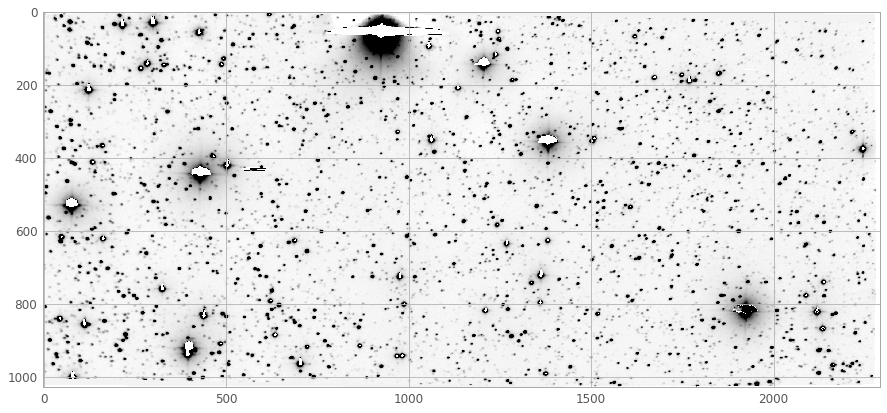

In [5]:
# READ THE IMAGE DATA
warnings.resetwarnings()
warnings.filterwarnings('ignore', category=UserWarning, append=True)
image_data = pyfits.getdata(infits, ext=0)
warnings.resetwarnings()

# SCALE AND DISPLAY THE IMAGE, and choose an appropriate sub-region
plt.figure(figsize=(15,30))
#plt.figure()
# In this we are using Contrast stretching, 
# and inverted grey scale for better display
p2, p98 = np.percentile(image_data, (2, 98))
img_rescale = exposure.rescale_intensity(image_data, in_range=(p2, p98))
plt.imshow(img_rescale, cmap='gray_r')

# Find the size of the image data array
[rows,cols] = image_data.shape
print('Number of rows, columns in image: %d %d' % (rows,cols))

### **STEP 3: ESTIMATE THE SKY BACKGROUND**

**These images have not been sky subtracted**. Therefore, the flux in any pixel contains contribution from the sky background. This sky background value has to be subtracted before we can do photometry (=measure the flux and magnitude of the stars). In this lab, _we will assume that the sky background is uniform over the entire image_. 

To estimate the sky background, we will use a sub-region of the image, which is relatively free of stars, but still large enough to give us robust statistical information. 

**Look at the image display above and choose an appropriate sub-region** Stay well away from the image edges, avoid saturated stars and other artefacts. We will estimate the mean, standard deviation and the median value of the flux in this sub-region.

**IMPORTANT NOTE: PYTHON IS ROW DOMINANT, SO WHILE CHOOSING SUB-REGIONS, THE FIRST SET OF COORDINATES RUNS THE IN THE VERTICAL DIRECTION (ROWS), AND THE SECOND SET RUNS ALONG THE HORIZONTAL DIRECTION (COLUMNS).**

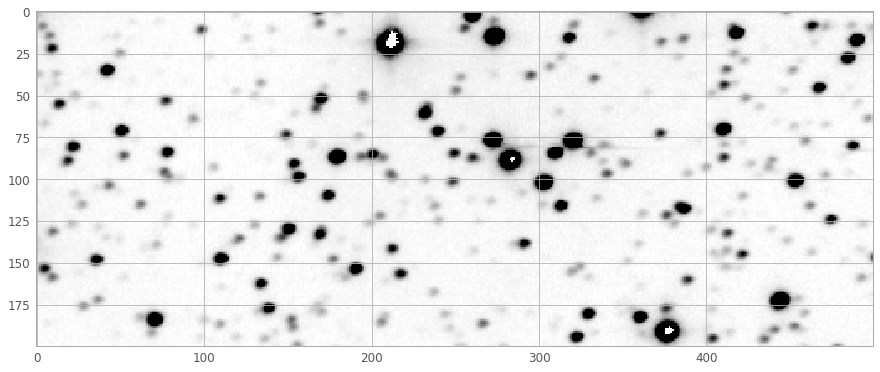

In [10]:
# Enter the row and column range of your chosen sub-region. 
# Recommended ranges: rows <= 250, columns <= 400 pixels
image_region = image_data[800:1000,1000:1500]

# SCALE AND DISPLAY THE IMAGE SUB-REGION
plt.figure(figsize=(15,30))
# In this we are using Contrast stretching, 
# and inverted grey scale for better display
p2, p98 = np.percentile(image_region, (2, 98))
img_rescale = exposure.rescale_intensity(image_region, in_range=(p2, p98))
plt.imshow(img_rescale, cmap='gray_r')

### **STEP 4: GET SOME BASIC STATISTICS OF THE SUB-REGION**

**NOTE** Even with careful choice of the sub-region, you will notice that there are (faint) stars, which skew the statistics. 

To check, this we will estimate the sky background in two stages:
    1. Estimate the mean, standard deviation and the median of the sub-region as such.
    2. Apply *sigma-clipping* algorithm to reject outliers, and re-estimate the statistics.
    
The effect of outliers is shown by the high standard deviation (=noise) in (1). By applying _sigma clipping_, we notice the noise goes down, and we get a better estimate of the sky background (= median value).

Sigma clipping is a useful technique to get **robust statistics in the presence of outliers**.


In [11]:
# SOME BASIC STATS OF TEH SUB-REGION NEEDED FOR SKY SUBTRACTION
print('Estimating the sky background')
mean = np.mean(image_region)
stddev = np.std(image_region)
median = np.median(image_region)
print('As input image: Mean, Stddev, Median : %9.1f %9.1f %9.1f ' % (mean,stddev,median))

## LET'S USE SIGMA CLIPPING TO REJECT OUTLIERS
## NOTE THAT WE RUN THIS ON THE WHOLE IMAGE IN ORDER TO OBTAIN ROBUST STATS
sc_mean, sc_median, sc_stddev = sigma_clipped_stats(image_region, sigma=5.0, iters=5)
print('After sigma clipping: Mean, Stddev, Median : %9.1f %9.1f %9.1f ' % (sc_mean,sc_stddev,sc_median))

Estimating the sky background
As input image: Mean, Stddev, Median :    1075.8     727.6    1001.6 
After sigma clipping: Mean, Stddev, Median :    1014.2      44.1    1000.5 


### **STEP 5: DETECTION OF STARS (SOURCES) USING DAOFIND**

**Use the statistical estimates to set the threshold and find the positions of the stars in the image**

Before we can measure the brightness of the stars in the image, we need to find their locations and also the optimal aperture size to use for measuring their flux. The aperture size is dependent on the point spread function (PSF) during the observation.

We will locate only the bright stars first using an approximate aperture size, then refine the aperture size based on one (user chosen) good star. In order to find only bright stars, we will set the detection threshold to be 20$\sigma$ above the sky background. The noise level, $\sigma$ is equal to the standard deviation *sc_stddev*

**_DAOFIND_ and _DAOPHOT II: The Next Generation_ were developed by Dr. Peter Stetson at the DAO, and has become an industry standard for crowded field astrometry and photometry.** Additional details are available online at various websites, such as <a href="http://www.star.bris.ac.uk/~mbt/daophot/" target="_blank">Starlink</a>. 

  id   xcentroid ycentroid sharpness ...  sky     peak    flux   mag  
------ --------- --------- --------- ... ----- --------- ------ ------
 1.000   260.665     1.687     0.400 ... 0.000  7200.478  7.950 -2.251
 2.000   418.373    12.432     0.486 ... 0.000  3599.953  3.359 -1.315
 3.000   273.915    14.234     0.457 ... 0.000 22778.041 22.190 -3.365
 4.000   318.178    15.332     0.476 ... 0.000  1724.398  1.625 -0.527
 5.000   490.222    16.679     0.431 ... 0.000  4019.068  3.977 -1.499
 6.000   484.917    27.271     0.440 ... 0.000  2520.597  2.513 -1.000
 7.000    42.353    34.539     0.462 ... 0.000  2192.792  2.045 -0.777
 8.000   467.740    45.042     0.454 ... 0.000  1850.468  1.850 -0.668
 9.000   169.803    51.657     0.441 ... 0.000  1748.029  1.589 -0.503
10.000   232.234    60.182     0.454 ... 0.000  2163.865  1.898 -0.696
   ...       ...       ...       ... ...   ...       ...    ...    ...
29.000   169.158   132.697     0.426 ... 0.000  1151.153  1.025 -0.026
30.000

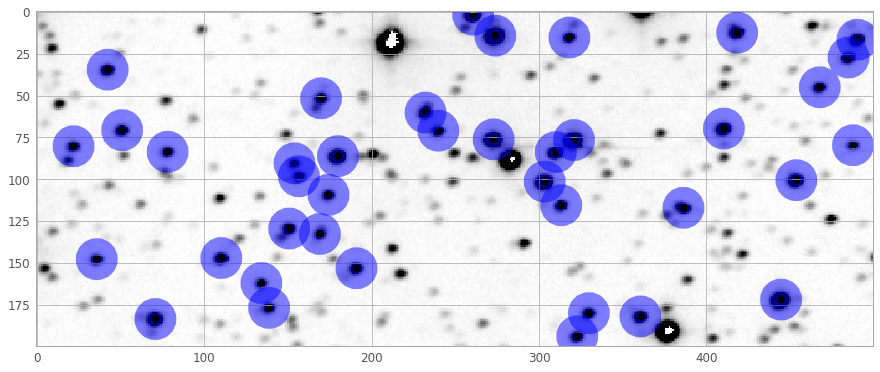

In [32]:
approx_fwhm = 5 # pixels
daofind = DAOStarFinder(fwhm=approx_fwhm, threshold=30.*sc_stddev)  #was 20 not 30
sources = daofind(image_region - sc_median)
for colname in sources.colnames:
    sources[colname].info.format = '%.3f'
print(sources)
print(type(sources))

## PLOT THE REGION AND OVERPLOT THE BRIGHT STARS
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=approx_fwhm)

plt.figure(figsize=(15,30))
p2, p98 = np.percentile(image_region, (2, 98))
img_rescale = exposure.rescale_intensity(image_region, in_range=(p2, p98))
plt.imshow(img_rescale, cmap='gray_r')
apertures.plot(color='blue', lw=5*approx_fwhm, alpha=0.5)

###  **STEP 6: CURVE OF GROWTH TO FIND THE OPTIMAL APERTURE**

In the DAOFind output table above, the locations of the bright stars are given by the columns _xcentroid_ and _ycentroid_. Choose any one of those stars which is unsaturated (without diffraction spikes).

Define a series of apertures of increasing size, and estimate the flux contained within each. Determine the optimal aperture as the one which contains all the flux without including too many sky pixels.

**NOTE: Test the following cell with several stars, and check if you get consistent values of the optimal aperture**.


Text(0,0.5,'Total flux [ADU]')

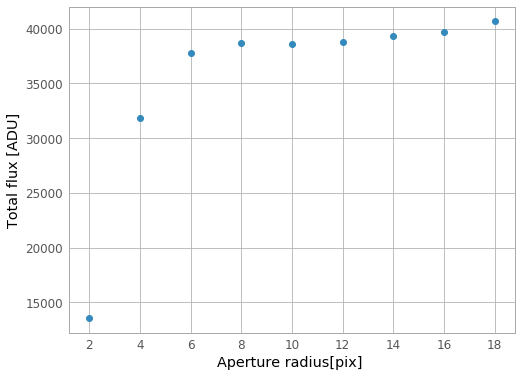

In [37]:
## CHOOSE ANY BRIGHT, UNSATURATED STAR FROM THE LIST ABOVE
## SPECIFY THE STAR TO USE BY THE STAR ID number
star_id = 31
star_num = star_id - 1
positions = [(sources['xcentroid'][star_num],sources['ycentroid'][star_num])]
## Create a list of apertures of increasing radius
aperture_list = range(2,20,2) ## min = 2 pix, max = 20 pix, step = 2
flux_list = [] ## create an empty list to hold the measured flux in each aperture
for aperture_radius in aperture_list:
    apertures = CircularAperture(positions, r=aperture_radius)
    phot_table = aperture_photometry(image_region-sc_median, apertures)
    flux_value = phot_table['aperture_sum'][0]
    flux_list.append(flux_value)

## Plot apertures versus measured flux, determine the optimal aperture size
plt.scatter(aperture_list, flux_list)
plt.xlabel('Aperture radius[pix] ')
plt.ylabel('Total flux [ADU]')

#### **Make a note of the optimal aperture radius ** 

We can see that the curve of growth _flattens_ or levels off with increasing radius. The radius at which this happens is the optimal aperture radius. Enter this value in the following code cell.   

**IMPORTANT** At much larger apertures, the flux continues to increase. This is due to contributions from sky noise as well as any nearby stars. _These should not be included in the estimate of the flux of the star_.

### **STEP 7: CARRY OUT APERTURE PHOTOMETRY ON ALL THE SOURCES IN THE IMAGE**

Now we are ready to detect all the sources in the full image and carry out aperture photometry to determine their magnitudes. Repeat the source detection and aperture photometry steps on the full image.

In [38]:
optimal_aperture = 10. ## determined above
approx_fwhm = optimal_aperture ## this is only used for source detection
nsigma = 3. ## this determines how faint we wish to go in detecting sources

## DETECT SOURCES IN TEH FULL IMAGE
daofind = DAOStarFinder(fwhm=optimal_aperture, threshold=nsigma*sc_stddev) 
sources = daofind(image_data - sc_median) ## detect sources in the full image

## NOW CARRY OUT APERTURE PHOTOMETRY ON ALL THE SOURCES
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=optimal_aperture)
phot_table = aperture_photometry(image_data - sc_median, apertures)
for colname in phot_table.colnames:
    phot_table[colname].info.format = '%.3f'
print(phot_table[:10])


  id   xcenter  ycenter aperture_sum
         pix      pix               
------ -------- ------- ------------
 1.000  762.933   9.495    39823.572
 2.000  471.849  10.022   107807.316
 3.000  676.115  10.182    10039.625
 4.000 2273.527  11.634  -102155.127
 5.000  209.955  11.286   322022.983
 6.000  504.393  11.824    29177.769
 7.000  516.124  11.904    13110.513
 8.000  928.354  18.004   434456.712
 9.000   50.401  12.934   166728.251
10.000  558.432  12.511    28175.695


### **STEP 8: Convert the total flux (given in _aperture sum_) to _magnitude_** 

The _aperture sum_ is in ADU. We need to covnert that into _apparent magnitude_ before we can build the luminosity function. For this conversion, we need the flux _Zero Point_ (ZP) of this image. The Zero Point is obtained by observing a _flux standard star_.

Apparent magnitude = -2.5 $log_{10}$(aperture sum) + ZP

**FOR THESE OBSERVATIONS, THE ZEROPOINT = 25**


In [41]:
# Flux zeropoint 
ZP = 25.

# extract the aperture sum column from the phot table
aperture_sum = phot_table['aperture_sum']

## You notice that some aperture sum values are negative
## remove thse values which are below zero (affected by bad pixels, bad CCD columns, etc.)
good_aperture_sum = [flux for flux in aperture_sum if flux > 0.]

## calculate the magnitude 
log10_flux = np.log10(good_aperture_sum)
apparent_magnitude = np.multiply(-2.5,log10_flux) + ZP

## check the selection step worked fine
print('%10s %10s' % ('Flux','Magnitude'))
for indx in range(10):
    print('%10.1f %10.3f' % (good_aperture_sum[indx],apparent_magnitude[indx]))

      Flux  Magnitude
   39823.6     13.500
  107807.3     12.418
   10039.6     14.996
  322023.0     11.230
   29177.8     13.837
   13110.5     14.706
  434456.7     10.905
  166728.3     11.945
   28175.7     13.875
  224802.9     11.620


### **STEP 9: CONSTRUCT THE LUMINOSITY FUNCTION**

Using these calculated magnitudes, we can now construct the _Luminosity Function_, as given in the lab manual. We need to plot the apparent magnitudes as a histogram.


Text(0,0.5,'# of sources')

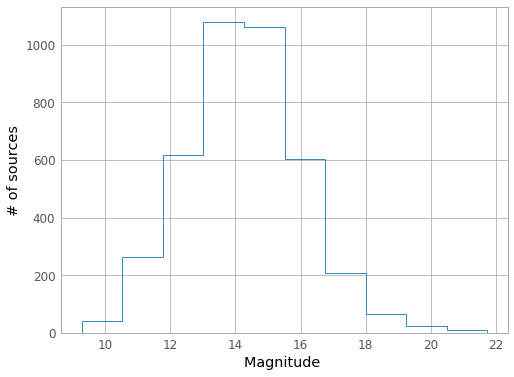

In [45]:
## Plot a simple histogram first to see the distribution of magnitudes
hist,mag_bin,_ = plt.hist(apparent_magnitude,histtype='step')
plt.xlabel('Magnitude ')
plt.ylabel('# of sources')
#completness turnover point due to limitation in detection by the telescope


The histogram shows that the number of stars increases as we go to fainter magnitudes (toward increasing values). However, the trend reverses and the number of stars decreases above apparent magnitude = 18 (in these observations). This is due to a drop in the _completeness_ (ask your TA about this) Therefore, for the Luminosity Function, we will only use the part of the histogram below magnitude = 18.

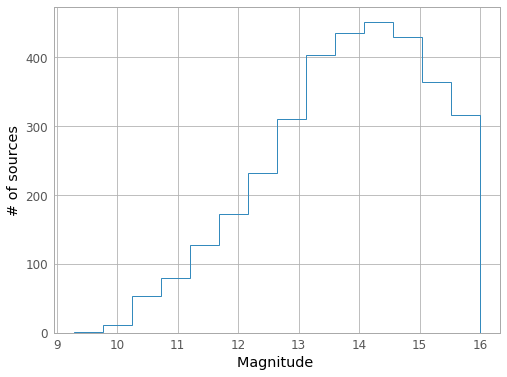

In [46]:
## Choose only the stars with magnitude < 20 (brighter than 20 magnitude)
completeness_limit = 16.
select_indices = [i for i in range(len(apparent_magnitude)) if apparent_magnitude[i] <= completeness_limit]
select_apparent_magnitude = apparent_magnitude[select_indices]
max_mag = max(select_apparent_magnitude)
min_mag = min(select_apparent_magnitude)
bin_size = 0.5
nbins = int(np.floor((max_mag - min_mag)/bin_size)+1)
hist,mag_bin,_ = plt.hist(select_apparent_magnitude,bins=nbins,histtype='step')
plt.xlabel('Magnitude ')
plt.ylabel('# of sources')

mag_bin = mag_bin[0:len(mag_bin)-1] ## trim off the last mag bin
# print(len(mag_bin))
# print(len(hist))

### **STEP 10: THE SLOPE OF THE LUMINOSITY FUNCTION**

Use the observed linear trend between mag_low and mag_high (user chosen) to fit a straight line to the log10 of the numbers of objects (shown in the histogram) versus the magnitude. Determine the slope of this line and compare it with the theoretical prediction of 0.6.

To fit a straight line, we will use a linear regression function available in the SciPy Stats package. The function returns the slope and also the error in the fitted value (along with other output not needed for our lab exercise).

Slope of luminosity function = 0.183
Fit error on slope 0.026
Intercept 0.121


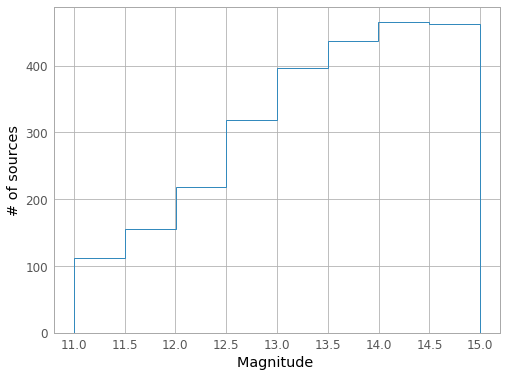

In [67]:
## choose these magnitude limits based on the plot above
mag_low = 11
mag_high = 15
## select only objects with magnitude between the chosen range
select_indices = [i for i in range(len(apparent_magnitude)) if ((apparent_magnitude[i] <= mag_high) and (apparent_magnitude[i] >= mag_low))]
select_apparent_magnitude = apparent_magnitude[select_indices]

## create the luminosity function with the selected objects
max_mag = max(select_apparent_magnitude)
min_mag = min(select_apparent_magnitude)
bin_size = 0.5
nbins = int(np.floor((max_mag - min_mag)/bin_size)+1)
select_hist,select_mag_bin,_ = plt.hist(select_apparent_magnitude,bins=nbins,histtype='step')
select_mag_bin = select_mag_bin[0:len(select_mag_bin)-1] ## trim off the last mag bin
log_hist = np.log10(select_hist)
plt.xlabel('Magnitude ')
plt.ylabel('# of sources')

## fit a straight line to log_hist versus select_mag
## we use a built-in function from scipy.stats
slope, intercept, r_value, p_value, std_err = sp_stats.linregress(select_mag_bin,log_hist)
print('Slope of luminosity function = %.3f' % slope)
print('Fit error on slope %.3f' % std_err)
print('Intercept %.3f' % intercept)

## **Plot and visually check the fitted slope**



Luminosity Function
  Observed     Fitted
       112      137.0
       156      169.1
       218      208.7
       318      257.6
       396      318.0
       437      392.5
       465      484.5
       462      598.0


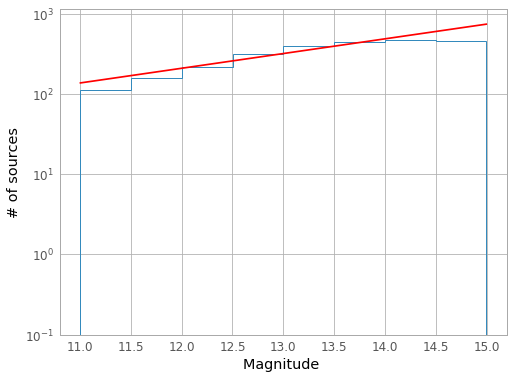

In [65]:
## regenerate the histogram using only objects within the selected mag range
## create a straight line with the fitted slope and intercept
## plot the histogram and overplot the fitted line
select_hist,select_mag_bin,_ = plt.hist(select_apparent_magnitude,bins=nbins,log=True,histtype='step')
fit_log_hist = intercept + np.multiply(slope,select_mag_bin)
fit_hist = np.power(10,fit_log_hist)
plt.xlabel('Magnitude ')
plt.ylabel('# of sources')
plt.plot(select_mag_bin,fit_hist,color='red')

print('Luminosity Function')
print('%10s %10s' % ('Observed','Fitted'))
for i in range(len(select_hist)):
     print('%10d %10.1f' % (select_hist[i],fit_hist[i]))

### **Generalize to the whole sky and discuss your results**

Answer the additional questions given in these two sections in the lab manual on a separate sheet of paper along with all the other needed sections (Objective/ Introduction, Procedure, etc). Submit a print out of the results from this program, along with the rest of the report and the marking rubric for marking.

**Important details regarding the Plaskett 1.8m telescope**

(You need this info to generalize to the whole sky)

The images used in this lab were taken at the 1.8m Plaskett telescope at the DAO with the Newtonian Imaging Camera. The field of view of the camera is 23.9 × 10.6 sq.arc.min. The detector is permanently aligned to the celestial north with the long axis of the detector in the east-west direction. The E2V CCD is generally binned by a factor of two to decrease the read out time. The scale on the detector is then 0.62'' per pixel.

In [44]:
## release all the plot handles and clean up
plt.close('all')